In [1]:
# Import dependencies

import matplotlib.pyplot as plt
import numpy as np
import itertools
import time, os, shutil, random, glob, warnings
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix

2024-10-19 19:10:40.480629: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 19:10:40.484010: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-19 19:10:40.493307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 19:10:40.508635: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 19:10:40.512951: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-19 19:10:40.524873: I tensorflow/core/platform/cpu_feature_gu

In [2]:
# Start measuring the time taken

start_time = time.time()
warnings.simplefilter(action='ignore', category=FutureWarning)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

## Doesn't work on native Windows with tensorflow > V 2.10
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


I0000 00:00:1729379459.759874   25037 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-19 19:10:59.760213: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Organize data into train, valid, test dirs
os.chdir('data/fire-vs-non_fire')

# Check if the directory is already exists first
if os.path.isdir('train/fire') is False:
    os.makedirs('train/fire')
    os.makedirs('train/non_fire')
    os.makedirs('valid/fire')
    os.makedirs('valid/non_fire')
    os.makedirs('test/fire')
    os.makedirs('test/non_fire')

    # There are 480 images. fire(240) & non_fire(240)
    # Train : Valid : Test = 8 : 2 : 2
    # Train: 320 (160, 160)
    # Valid: 80 (40, 40)
    # Test: 80 (40, 40)
    for c in random.sample(glob.glob('fire*'), 160):
        shutil.move(c, 'train/fire')
    for c in random.sample(glob.glob('non_fire*'), 160):
        shutil.move(c, 'train/non_fire')
    for c in random.sample(glob.glob('fire*'), 40):
        shutil.move(c, 'valid/fire')
    for c in random.sample(glob.glob('non_fire*'), 40):
        shutil.move(c, 'valid/non_fire')
    for c in random.sample(glob.glob('fire*'), 40):
        shutil.move(c, 'test/fire')
    for c in random.sample(glob.glob('non_fire*'), 40):
        shutil.move(c, 'test/non_fire')

os.chdir('../../')

# Path to the different dataset directories
train_path = 'data/fire-vs-non_fire/train'
valid_path = 'data/fire-vs-non_fire/valid'
test_path = 'data/fire-vs-non_fire/test'

# Directory iterator
train_batches = ImageDataGenerator(preprocessing_function=
    tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=train_path, target_size=(224, 224),  batch_size=16)
valid_batches = ImageDataGenerator(preprocessing_function=
    tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=valid_path, target_size=(224, 224),  batch_size=16)
test_batches = ImageDataGenerator(preprocessing_function=
    tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(
    directory=test_path, target_size=(224, 224),  batch_size=16, shuffle=False)

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [4]:
# Checks if datasets are accurate
assert train_batches.n == 320
assert valid_batches.n == 80
assert test_batches.n == 80
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [5]:
# To show train images after being pre-processed
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


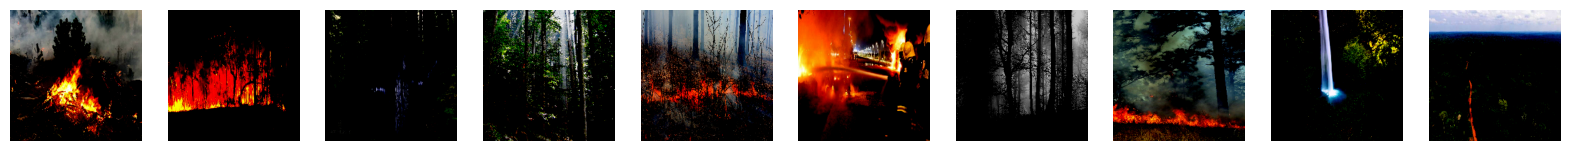

In [6]:
# Displays some images in train directory after they are pre-processed
imgs, labels = next(train_batches)
print(labels)  
plotImages(imgs)

In [7]:
# Fine tuning our CNN to work with our dataset and starting the training
mobile = MobileNetV2()
# mobile.summary()   # This line was to show the layers of our CNN

x = mobile.layers[0].output
output = Flatten()(x)
output = Dense(units=2, activation = 'sigmoid')(output)
model = Model(inputs=mobile.input, outputs = output)
tf.keras.optimizers.Adam()
model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = 'binary_crossentropy', metrics =['accuracy'])
model.fit(train_batches, validation_data=valid_batches, epochs=10, verbose = 2)

/home/jinho/fire-detection/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
20/20 - 5s - 228ms/step - accuracy: 0.7312 - loss: 0.5996 - val_accuracy: 0.8375 - val_loss: 0.4777
Epoch 2/10
20/20 - 4s - 190ms/step - accuracy: 0.9312 - loss: 0.1708 - val_accuracy: 0.8625 - val_loss: 0.3778
Epoch 3/10
20/20 - 4s - 194ms/step - accuracy: 0.9750 - loss: 0.0891 - val_accuracy: 0.8625 - val_loss: 0.3010
Epoch 4/10
20/20 - 4s - 194ms/step - accuracy: 0.9844 - loss: 0.0789 - val_accuracy: 0.8125 - val_loss: 0.4364
Epoch 5/10
20/20 - 4s - 192ms/step - accuracy: 0.9656 - loss: 0.0841 - val_accuracy: 0.8125 - val_loss: 0.4360
Epoch 6/10
20/20 - 4s - 191ms/step - accuracy: 0.9875 - loss: 0.0590 - val_accuracy: 0.8125 - val_loss: 0.4479
Epoch 7/10
20/20 - 4s - 190ms/step - accuracy: 0.9969 - loss: 0.0387 - val_accuracy: 0.9000 - val_loss: 0.3836
Epoch 8/10
20/20 - 4s - 190ms/step - accuracy: 0.9875 - loss: 0.0443 - val_accuracy: 0.8125 - val_loss: 0.4364
Epoch 9/10
20/20 - 4s - 191ms/step - accuracy: 1.0000 - loss: 0.0244 - val_accuracy: 0.8750 - val_loss: 0.3403
E

In [8]:
# A function to plot a confusion matrix

def plot_confusion_matrix(cm, classes, normalize= False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matix, without normalization')

    print(cm)

    # Calculate accuracy
    total_samples = np.sum(cm)
    correct_predictions = np.sum(np.diag(cm))
    accuracy = correct_predictions / total_samples
    print("Detection Accuracy: {:.2f}%".format(accuracy * 100))

    # Calculate precision and recall
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)

    for i, cls in enumerate(classes):
        print("")
        print("Precision for {}: {:.2f}%".format(cls, precision[i] * 100))
        print("Recall for {}: {:.2f}%".format(cls, recall[i] * 100))

    thresh = cm.max() /2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j], horizontalalignment="center", color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [9]:
# Preparing data to be tested and then making a confusion matrix with the results
test_labels = test_batches.classes
predicitons = model.predict(x=test_batches, verbose =0)
cm = confusion_matrix(y_true = test_labels, y_pred=predicitons.argmax(axis=1))
test_batches.class_indices
cm_plot_labels = ['fire', 'non-fire']

Elapsed time: 78.90 seconds
Confusion matix, without normalization
[[37  3]
 [ 1 39]]
Detection Accuracy: 95.00%

Precision for fire: 97.37%
Recall for fire: 92.50%

Precision for non-fire: 92.86%
Recall for non-fire: 97.50%


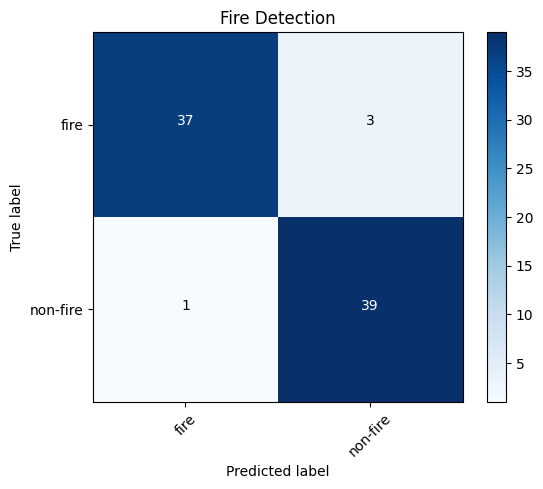

In [10]:
# Outputting total time, confusion matrix, and accuracies 
end_time = time.time()
elapsed_time = end_time - start_time
print("Elapsed time: {:.2f} seconds".format(elapsed_time))
plot_confusion_matrix(cm=cm, classes =cm_plot_labels, title = 'Fire Detection')